In [36]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import xgboost as xgb

In [44]:
# Simulation parameters
TimeSplit_up = "2009-01-01"
TimeSplit_down = "2008-01-1"
starting_cash = 1000

In [47]:
# --- Carica dati e modello ---

with open("stocks.txt", "r") as f:
    stocks = [line.strip() for line in f if line.strip()]

models = {}

for tiker in stocks:
    df = pd.read_csv(
        f"csv/{tiker}_indicators.csv",
        index_col=0,
        parse_dates=[0],
        date_format="ISO8601"
    )

    bundle = joblib.load(f"models/{tiker}.joblib")
    model = bundle["model"]
    features = bundle["features"]
    scaler = bundle.get("scaler", None) 

    # use elementwise boolean with & and ensure datetime comparison
    start_dt = pd.to_datetime(TimeSplit_down)
    end_dt = pd.to_datetime(TimeSplit_up)
    models[f"{tiker}"] = {
        "model": model,
        "features": features,
        "scaler": scaler,
        "test_data": df[(df.index>=start_dt) & (df.index <= end_dt)],
        "threshold": bundle["threshold"]
    }
    

==========AAPL==========
0.2699999999999999
Baseline 1: Soldi di partenza: 1000 | Soldi alla fine 438.0517174425508 | Guadagno -56.195 %
Baseline 2: Soldi di partenza: 1000 | Soldi alla fine 705.5706099080721 | Guadagno -29.443 %
Modello: Soldi di partenza: 1000 | Soldi alla fine 438.0517174425508 | Guadagno -56.195 %


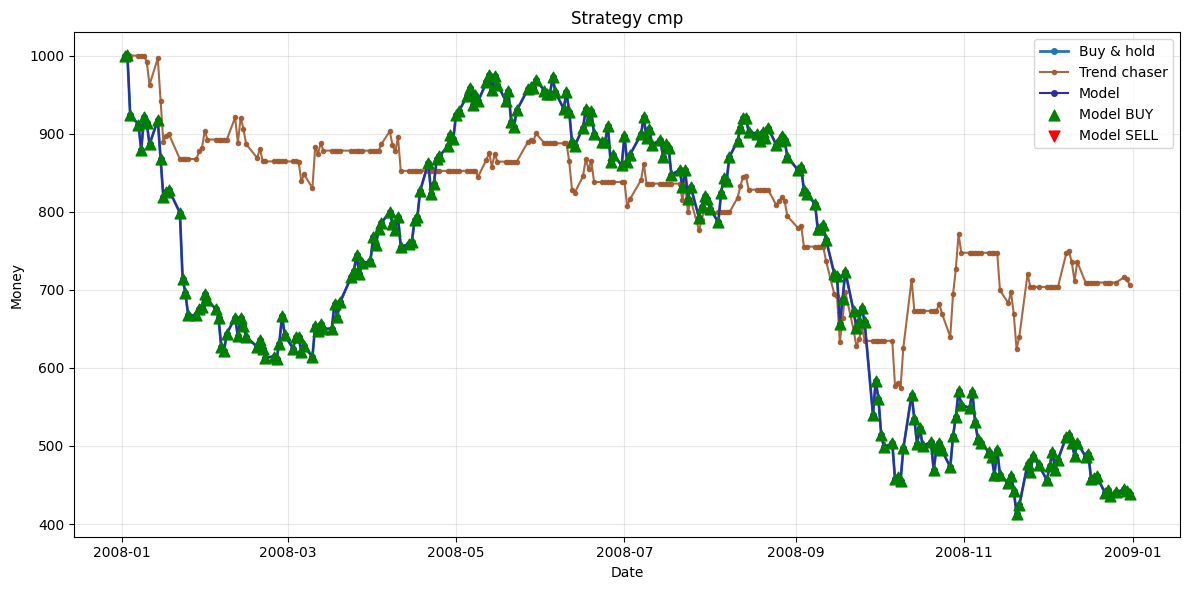

In [48]:
for tiker, data in models.items():
    print("=" * 10 + f"{tiker}" + "=" * 10)

    # Baseline trading stategy: buy and hold
    number_of_actions = starting_cash / data["test_data"].iloc[0]["Close"]
    payout_bnh = number_of_actions * data["test_data"].iloc[-1]["Close"]

    # Second baseline: trend chaser (apply-based) 
    trand_chaser = {
        "cash": starting_cash,
        "shares": 0.0,
        "prev_price": None,
        "streak": 0,
        "trashold": 3,
        "data": data["test_data"].copy()
    }

    def step(row):
        price = float(row["Close"])
        prev = trand_chaser["prev_price"]

        # initialize on first row
        if prev is None:
            trand_chaser["prev_price"] = price
            portfolio = trand_chaser["cash"] + trand_chaser["shares"] * price
            return portfolio

        # replicate the original decision logic
        if trand_chaser["shares"] <= 0:
            # bear
            if prev > price:
                trand_chaser["streak"] += 1
            else:
                if trand_chaser["streak"] >= trand_chaser["trashold"]:
                    # original code added more shares using all cash
                    trand_chaser["shares"] += trand_chaser["cash"] / price
                    trand_chaser["cash"] = 0.0
                    trand_chaser["streak"] = 0
        else:
            # Bull
            if prev <= price:
                trand_chaser["streak"] += 1
            else:
                if trand_chaser["streak"] >= trand_chaser["trashold"]:
                    # original code sold shares (though shares==0 here in original), keep same behaviour
                    trand_chaser["cash"] += trand_chaser["shares"] * price
                    trand_chaser["shares"] = 0.0
                    trand_chaser["streak"] = 0

        trand_chaser["prev_price"] = price
        portfolio = trand_chaser["cash"] + trand_chaser["shares"] * price

        # Debug print
        #print(f"data : {row.name.strftime("%Y-%m-%d")} | shares : {state['shares']} | cash: {state['cash']} | price : {("Bear" if (state["prev_price"] > price) else "Bull")} | {state["streak"]}")

        return portfolio
    
    trand_chaser["data"].loc[:, "portfolio_value"] = trand_chaser["data"].apply(step, axis=1)
    payout_tc = trand_chaser["cash"] + (trand_chaser["shares"] * trand_chaser["data"].iloc[-1]["Close"])

    # Model
    state_modello = {
        "cash": starting_cash,
        "shares": 0.0,
        "data": data["test_data"].copy(),
        "prev_price": None,
        "streak": 0,
        "trashold": 3,
    }

    # prepare feature matrix and apply scaler (if present)
    feat_df = state_modello["data"][data["features"]].copy()
    feat_df = feat_df.ffill()   # handle NaNs; choose appropriate strategy

    # helper: build DMatrix or raw array depending on saved model type
    def _features_to_input(df_rows, features, scaler=None, model=None):
        Xf = df_rows[features].copy()
        Xf = Xf.ffill()
        if scaler is not None:
            # scaler.transform returns ndarray
            X_scaled = scaler.transform(Xf)
        else:
            # keep as DataFrame values by default
            X_scaled = Xf.values

        # if model is an XGBoost Booster (trained with xgb.train), use DMatrix
        # When a Booster was trained with feature names, xgboost expects the incoming
        # DMatrix to include feature_names. Provide them to avoid the ValueError.
        if model is not None and hasattr(model, "predict") and not hasattr(model, "predict_proba"):
            try:
                return xgb.DMatrix(X_scaled, feature_names=features)
            except Exception:
                # fallback to DMatrix without explicit feature names if something goes wrong
                return xgb.DMatrix(X_scaled)
        # else return raw array (works for sklearn wrappers like XGBClassifier)
        return X_scaled

    model_obj = data["model"]

    # If the model exposes predict_proba (sklearn-like),
    # pass a DataFrame with feature names (or scaled DataFrame) so feature name checks pass.
    if hasattr(model_obj, "predict_proba"):
        X_for_pred = feat_df.copy().ffill()
        if data.get("scaler", None) is not None:
            # keep feature names after scaling to satisfy estimators that check feature names
            scaled_arr = data["scaler"].transform(X_for_pred)
            X_for_pred = pd.DataFrame(scaled_arr, index=X_for_pred.index, columns=data["features"])
        # call sklearn-like API with DataFrame (keeps column names)
        probs = model_obj.predict_proba(X_for_pred)[:, 1]
    else:
        # xgboost.Booster (from xgb.train) expects a DMatrix
        inp = _features_to_input(feat_df, data["features"], scaler=data.get("scaler", None), model=model_obj)
        probs = model_obj.predict(inp)

    # convert to class actions (1 if tomorrow will be higher)
    thresh = 0.5

    if(data["threshold"] != None):
        thresh = data["threshold"]

    actions = (probs >= thresh).astype(int)
    state_modello["data"].loc[:, "model_action"] = actions
    print(thresh)
    #def model_action(row):
    #    price = float(row["Close"])
    #    prev = state_modello["prev_price"]
    #    action = row["model_action"]

    #    # initialize on first row
    #    if prev is None:
    #        state_modello["prev_price"] = price
    #        portfolio = state_modello["cash"] + (state_modello["shares"] * price)
    #        return portfolio

    #    # replicate the original decision logic
    #    if state_modello["shares"] <= 0:
    #        # bear
    #        if prev > price :
    #            state_modello["streak"] += 1
    #        else:
    #            if state_modello["streak"] >= state_modello["trashold"] and row["model_action"] == 1:
    #                state_modello["shares"] += state_modello["cash"] / price
    #                state_modello["cash"] = 0.0
    #                state_modello["streak"] = 0
    #    else:
    #        # Bull
    #        if prev <= price:
    #            state_modello["streak"] += 1
    #        else:
    #            if state_modello["streak"] >= state_modello["trashold"] and row["model_action"] == 0:
    #                # original code sold shares (though shares==0 here in original), keep same behaviour
    #                state_modello["cash"] += state_modello["shares"] * price
    #                state_modello["shares"] = 0.0
    #                state_modello["streak"] = 0

    #    state_modello["prev_price"] = price
    #    portfolio = state_modello["cash"] + state_modello["shares"] * price


    #    #print(f" date: {row.name.strftime("%Y-%m-%d")} | signal : {action} | cash: {state_modello["cash"]} | shares: {state_modello["shares"]}")
    #    return state_modello["cash"] + state_modello["shares"] * price

    def model(row):
        price = float(row["Close"])

        if state_modello["shares"] == 0 and row["model_action"] == 1:
            #hard buy
            state_modello["shares"] += state_modello["cash"] / price
            state_modello["cash"] = 0.0
            state_modello["streak"] = 0
        
        if state_modello["shares"] != 0 and row["model_action"] == 0:
            #Hard sell
            state_modello["cash"] += state_modello["shares"] * price
            state_modello["shares"] = 0.0
            state_modello["streak"] = 0
            
        return state_modello["cash"] + (state_modello["shares"] * price)


    # assign results explicitly with .loc
    state_modello["data"].loc[:, "model_value"] = state_modello["data"].apply(model, axis=1)

    # final payout following the same formula used previously
    payout_mod = state_modello["cash"] + (state_modello["shares"] * state_modello["data"].iloc[-1]["Close"])
    

    print(f"Baseline 1: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_bnh} | Guadagno {((payout_bnh - starting_cash)/starting_cash) * 100:.3f} %")
    print(f"Baseline 2: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_tc} | Guadagno {((payout_tc - starting_cash)/starting_cash) * 100:.3f} %")
    print(f"Modello: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_mod} | Guadagno {((payout_mod - starting_cash)/starting_cash) * 100:.3f} %")
    
    plt.figure(figsize=(12,6))

    idx = data["test_data"].index
    bh_series = data["test_data"]["Close"] * number_of_actions
    tc_series = trand_chaser["data"]["portfolio_value"]
    model_series = state_modello["data"]["model_value"]

    # plot lines with daily markers
    plt.plot(idx, bh_series, label='Buy & hold', color='#1f77b4', linewidth=2, marker='o', markersize=4)
    plt.plot(idx, tc_series, label='Trend chaser', color="#a0582c", linewidth=1.5, marker='o', markersize=3, alpha=0.9)
    plt.plot(idx, model_series, label='Model', color="#2e2ca0", linewidth=1.5, marker='o', markersize=4)

    # overlay buy/sell markers using model_action (show at model_value)
    buys = state_modello["data"]["model_action"] == 1
    sells = state_modello["data"]["model_action"] == 0

    plt.scatter(state_modello["data"].loc[buys].index, state_modello["data"].loc[buys, "model_value"],
                marker="^", color="green", s=60, label="Model BUY", zorder=5)
    plt.scatter(state_modello["data"].loc[sells].index, state_modello["data"].loc[sells, "model_value"],
                marker="v", color="red", s=60, label="Model SELL", zorder=5)

    plt.title("Strategy cmp")
    plt.xlabel("Date")
    plt.ylabel("Money")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()